In [87]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Sequential
from keras.models import load_model
from keras.models import Model
from keras.layers import Dense
from keras.layers.merge import concatenate

from matplotlib import pyplot
from os import makedirs
from numpy import dstack
from numpy import argmax

### Based Line 

Train: 0.830, Test: 0.804


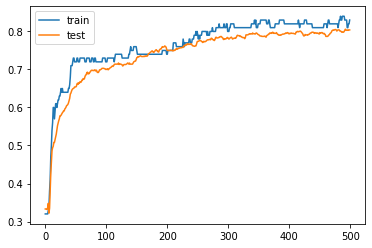

In [2]:
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
y = to_categorical(y)

n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

### Stacked Generalization Ensemble

In [48]:
def FitModel(X_train, y_train):
  model = Sequential()
  model.add(Dense(25, input_dim=2, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(X_train, y_train, epochs=500, verbose=0)
  
  return model

In [69]:
def CreateModelsDirectory(X_train, y_train):
  makedirs('models')
  n_members = 5

  for i in range(n_members):
    model = FitModel(X_train, y_train)
    filename = 'models/model_' + str(i + 1) + '.h5'
    model.save(filename)
    print('>Saved %s' % filename)

In [57]:
def LoadModels(n_models):
  models = list()

  for i in range(n_models):
    filename = 'models/model_' + str(i + 1) + '.h5'
    model = load_model(filename)
    models.append(model)
  
  return models

In [58]:
def StackModel(models, inputX):
  stackX = None
  for model in models:
    yhat = model.predict(inputX, verbose=0)

    if stackX is None:
      stackX = yhat
    else:
      stackX = dstack((stackX, yhat))

  stackX = stackX.reshape((stackX.shape[0], stackX.shape[1] * stackX.shape[2]))
  
  return stackX

In [59]:
def FitStackedModel(models, inputX, inputy):
	stackedX = StackModel(models, inputX)
	model = LogisticRegression()
	model.fit(stackedX, inputy)
	return model

In [60]:
def StackedModelPrediction(models, model, inputX):
	stackedX = StackModel(models, inputX)
	yhat = model.predict(stackedX)
	return yhat

In [71]:
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
n_train = 100
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]
y_train = to_categorical(y_train)

CreateModelsDirectory(X_train, y_train)

n_members = 5
models = LoadModels(n_members)
print('Loaded %d models' % len(models))

for model in models:
	testy_enc = to_categorical(y_test)
	_, acc = model.evaluate(X_test, testy_enc, verbose=0)
	print('Model Accuracy: %.3f' % acc)

model = FitStackedModel(models, X_test, y_test)
yhat = StackedModelPrediction(models, model, X_test)
acc = accuracy_score(y_test, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

>Saved models/model_1.h5
>Saved models/model_2.h5
>Saved models/model_3.h5
>Saved models/model_4.h5
>Saved models/model_5.h5
Loaded 5 models
Model Accuracy: 0.802
Model Accuracy: 0.812
Model Accuracy: 0.807
Model Accuracy: 0.813
Model Accuracy: 0.811
Stacked Test Accuracy: 0.826


### Integrated Stacking Model

In [74]:
def DefineStackedModels(models):
	for i in range(len(models)):
		model = models[i]
		for layer in model.layers:
			layer.trainable = False
			layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

	ensemble_visible = [model.input for model in models]
	ensemble_outputs = [model.output for model in models]
	merge = concatenate(ensemble_outputs)
	hidden = Dense(10, activation='relu')(merge)
	output = Dense(3, activation='softmax')(hidden)
	model = Model(inputs=ensemble_visible, outputs=output)

	plot_model(model, show_shapes=True, to_file='model_graph.png')
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [75]:
def FitStackedModel(model, inputX, inputy):
	X = [inputX for _ in range(len(model.input))]
	inputy_enc = to_categorical(inputy)
	model.fit(X, inputy_enc, epochs=300, verbose=0)

In [76]:
def PredictStackedModel(model, inputX):
	X = [inputX for _ in range(len(model.input))]
	return model.predict(X, verbose=0)

In [88]:
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

n_members = 5
members = LoadModels(n_members)

stacked_model = DefineStackedModels(members)
FitStackedModel(stacked_model, testX, testy)
yhat = PredictStackedModel(stacked_model, testX)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

Stacked Test Accuracy: 0.830
